# Trans-xQTL fine-mapping analysis in the APOE TAD region

Date: Sep 11, 2025

We performed xQTL-wide trans-xQTL fine-mapping analysis using SuSiE on the APOE TAD region (chr19:41840000-47960000). Trans-xQTL fine-mapping analyses were conducted separately across four each of single-xQTL context.

This notebook is a summary of the trans-xQTL fine-mapping results of variants in APOE TAD region, including the following sections:
1. *Extract variants in APOE TAD region and summary of trans-xQTL results*: This section identifies trans-xQTL within the APOE TAD region and provides an overview of their sharing patterns. It offers a comprehensive landscape of regulatory relationships across the entire TAD region.
2. *Connect fine-mapped trans-xQTL to APOE2 and APOE4 - LD between xQTL and two loci*: This section examines the linkage disequilibrium relationships between identified colocalized xQTLs and the two key APOE loci. It determines whether colocalized signals are independent with APOE $\epsilon$2/APOE $\epsilon$4.

## 1. Summary of trans-xQTL results of APOE TAD region
Only consider 5616 xQTL within APOE TAD region.

- These 5616 trans-xQTL spans 406 95\% CS. To get the number of independent sets of variants, we merged the sets if the cummulative summation of PIP for overlapped variants are greater than 0.5 for **each set**. That means, assuming cs (snp1, snp2, snp3) and cs2 (snp2, snp3, snp4), we merge cs1 and cs2 if and only if PIP(snp2+snp3)>0.5 calculated in cs1 and PIP(snp2+snp3)>0.5 calculated in cs2. A total of 286 independent sets identified in APOE TAD region.
- The majority of trans-xQTL occur in MSBB cohorts and Knight_eQTL, ROSMAP Monocyte, ROSMAP gpQTL. MIGA cohort datasets and **all ROSMAP sQTL** lack analyzable xQTL signals in the APOE region.

In [2]:
setwd("/data1/deyk/xuewei/colocboost/pipeline/columbia/APOE")
library(tidyverse)
library(data.table)

In [8]:
trans_toploci <- fread("/data1/deyk/xuewei/colocboost/pipeline/columbia/APOE/FunGen_xQTL.trans.exported.toploci.bed.gz")
trans_toploci <- trans_toploci %>% filter(cs_coverage_0.95 != 0)
trans_toploci %>% dim
trans_toploci %>% head(n=1)

[1] 1683487      20

#chr,start,end,a1,a2,variant_ID,MAF,betahat,sebetahat,z,gene_ID,event_ID,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5,PIP,conditional_effect,resource,p,cs_id
<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,1593619,1593620,C,G,chr1:1593620:G:C,0.1384181,0.5165502,0.09126267,5.660038,chr1_16103_2888443,Knight_eQTL_ENSG00000260644,1,1,1,0.1218043,0.4950032,Knight_eQTL,1.513391e-08,chr1_16103_2888443_Knight_eQTL_ENSG00000260644_1


In [5]:
gene_TAD <- data.table::fread("/data1/deyk/ftp_fgc_xqtl/utils/TADB_enhanced_cis.coding.bed")
APOE_TAD <- gene_TAD %>% filter(gene_id == "ENSG00000130203")
APOE_TAD

#chr,start,end,gene_id
<chr>,<int>,<int>,<chr>
chr19,41840000,47960000,ENSG00000130203


In [9]:
trans_in_APOE <- trans_toploci %>% filter( `#chr` == 19 & start > APOE_TAD$start & end < APOE_TAD$end)
trans_in_APOE %>% dim
trans_in_APOE %>% head(n=1)

[1] 5616   20

#chr,start,end,a1,a2,variant_ID,MAF,betahat,sebetahat,z,gene_ID,event_ID,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5,PIP,conditional_effect,resource,p,cs_id
<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
19,41924614,41924615,G,A,chr19:41924615:A:G,0.3375706,0.07482203,0.01500462,4.986599,chr19_41137068_42346101,Knight_eQTL_ENSG00000198846,1,0,0,0.03329592,0.06576609,Knight_eQTL,6.145156e-07,chr19_41137068_42346101_Knight_eQTL_ENSG00000198846_1


In [10]:
trans_in_APOE %>% pull(cs_id) %>% unique %>% length
cos <- trans_in_APOE$cs_id %>% unique
cos %>% length

[1] 406

[1] 406

In [12]:
source("merge_coloc_also_within_loci.R")
threshold <- 0.5
flat_cos <- lapply(1:length(cos), function(i){
    pos <- which(trans_in_APOE$cs_id == cos[i])
    trans_in_APOE$variant_ID[pos]
})
flat_cos_vcp <- lapply(1:length(cos), function(i){
    pos <- which(trans_in_APOE$cs_id == cos[i])
    trans_in_APOE$PIP[pos] %>% as.numeric
})
merge_pairwise_idx <- get_merge_pairwise_idx(flat_cos, flat_cos_vcp, threshold = threshold)
flat_coloc_outcome <- lapply(1:length(cos), function(i){
    pos <- which(trans_in_APOE$cs_id == cos[i])
    tmp <- trans_in_APOE$event_ID[pos] %>% unique
    tmp <- lapply(tmp, function(tt) strsplit(tt, "; ")[[1]] )
    tmp %>% unlist %>% unique
})

In [13]:
length(merge_pairwise_idx)

[1] 286

In [14]:
final_cos <- final_vcp <- list()
final_colocOutcome <- c()
for (ii in 1:length(merge_pairwise_idx)){
    p.merge <- merge_pairwise_idx[[ii]]
    # - coloc outcomes 
    oo <- flat_coloc_outcome[p.merge] %>% unlist
    colocOutcome <- paste0(unique(oo), collapse = "; ")
    # - coloc CoS and pph4
    snps <- unlist(flat_cos[p.merge])
    vcps <- unlist(flat_cos_vcp[p.merge])
    context_df <- data.frame(SNP = snps, vcp = vcps, stringsAsFactors = FALSE)
    unique_snps <- unique(context_df$SNP)
    max_vcp <- sapply(unique_snps, function(snp) {
      max(context_df$vcp[context_df$SNP == snp], na.rm = TRUE)
      # min(context_df$vcp[context_df$SNP == snp], na.rm = TRUE)
    })
    merged_df <- data.frame(SNP = unique_snps, MaxVCP = max_vcp, stringsAsFactors = FALSE)
    cos <- merged_df$SNP
    vcp <- merged_df$MaxVCP
    # - coloc purity
    final_cos <- c(final_cos, list(cos))
    final_vcp <- c(final_vcp, list(vcp))
    final_colocOutcome <- c(final_colocOutcome, colocOutcome)
}
names(final_cos) <- 
    names(final_vcp) <- 
    names(final_colocOutcome) <- 
    paste0("ind_cos_", 1:length(merge_pairwise_idx))

In [45]:
contexts <- list(
    MIGA = c("MIGA_GFM", "MIGA_GTS", "MIGA_SVZ", "MIGA_THA"),
    MSBB = c("MSBB_eQTL_BM10", "MSBB_eQTL_BM22", "MSBB_eQTL_BM36", "MSBB_eQTL_BM44", "MSBB_pQTL_BM36"),
    KNIGHT = c("Knight_eQTL", "Knight_pQTL"),
    STARNET = c("STARNET_eQTL"),
    ROSMAP = c("ROSMAP_pQTL", "ROSMAP_adjusted_gpQTL", "ROSMAP_gpQTL", 
               "ROSMAP_DeJager_AC_sQTL", "ROSMAP_DeJager_DLPFC_sQTL", "ROSMAP_DeJager_PCC_sQTL",
              "ROSMAP_DeJager_eQTL_Ast", "ROSMAP_DeJager_eQTL_Mic", "ROSMAP_DeJager_eQTL_Exc", "ROSMAP_DeJager_eQTL_Inh", 
              "ROSMAP_DeJager_eQTL_OPC", "ROSMAP_DeJager_eQTL_Oli",
              "ROSMAP_Kellis_eQTL_Ast", "ROSMAP_Kellis_eQTL_Mic", "ROSMAP_Kellis_eQTL_Exc", "ROSMAP_Kellis_eQTL_Inh", 
               "ROSMAP_Kellis_eQTL_OPC", "ROSMAP_Kellis_eQTL_Oli",
              "ROSMAP_mega_eQTL_Ast", "ROSMAP_mega_eQTL_Mic", "ROSMAP_mega_eQTL_Exc", "ROSMAP_mega_eQTL_Inh",
              "ROSMAP_mega_eQTL_OPC", "ROSMAP_mega_eQTL_Oli",
              "ROSMAP_DeJager_eQTL_PCC", "ROSMAP_DeJager_eQTL_AC", "ROSMAP_DeJager_eQTL_DLPFC", "ROSMAP_DeJager_eQTL_Monocyte")
) %>% unlist
all_contexts <- c(contexts)
names(all_contexts) <- c(contexts)
all_contexts %>% length

[1] 40

In [48]:
coloc <- vector("list", length(all_contexts)) %>% setNames(all_contexts)
coloc <- lapply(all_contexts, function(ac){
    pos <- sapply(final_colocOutcome, function(fc){ grepl(ac, fc) }) %>% which
    names(final_colocOutcome)[pos]
})
sapply(coloc, length)

MIGA_GFM                     MIGA_GTS 
                           0                            0 
                    MIGA_SVZ                     MIGA_THA 
                           0                            0 
              MSBB_eQTL_BM10               MSBB_eQTL_BM22 
                          25                           24 
              MSBB_eQTL_BM36               MSBB_eQTL_BM44 
                          28                           25 
              MSBB_pQTL_BM36                  Knight_eQTL 
                          16                           38 
                 Knight_pQTL                 STARNET_eQTL 
                           1                           15 
                 ROSMAP_pQTL        ROSMAP_adjusted_gpQTL 
                           8                           28 
                ROSMAP_gpQTL       ROSMAP_DeJager_AC_sQTL 
                          18                            0 
   ROSMAP_DeJager_DLPFC_sQTL      ROSMAP_DeJager_PCC_sQTL 
                           0                            0 
     ROSMAP_DeJager_eQTL_Ast      ROSMAP_DeJager_eQTL_Mic 
                           5                            6 
     ROSMAP_DeJager_eQTL_Exc      ROSMAP_DeJager_eQTL_Inh 
                           5                            3 
     ROSMAP_DeJager_eQTL_OPC      ROSMAP_DeJager_eQTL_Oli 
                           5                            9 
      ROSMAP_Kellis_eQTL_Ast       ROSMAP_Kellis_eQTL_Mic 
                           7                            5 
      ROSMAP_Kellis_eQTL_Exc       ROSMAP_Kellis_eQTL_Inh 
                           5                            9 
      ROSMAP_Kellis_eQTL_OPC       ROSMAP_Kellis_eQTL_Oli 
                           8                           15 
        ROSMAP_mega_eQTL_Ast         ROSMAP_mega_eQTL_Mic 
                           3                            2 
        ROSMAP_mega_eQTL_Exc         ROSMAP_mega_eQTL_Inh 
                           4                            8 
        ROSMAP_mega_eQTL_OPC         ROSMAP_mega_eQTL_Oli 
                           2                            2 
     ROSMAP_DeJager_eQTL_PCC       ROSMAP_DeJager_eQTL_AC 
                          14                            7 
   ROSMAP_DeJager_eQTL_DLPFC ROSMAP_DeJager_eQTL_Monocyte 
                           8                           30

In [49]:
pos_no_coloc <- which( sapply(coloc, length) != 0 )
names(coloc)[-pos_no_coloc]
coloc <- coloc[pos_no_coloc]
all_contexts <- all_contexts[pos_no_coloc]

[1] "MIGA_GFM"                  "MIGA_GTS"                 
[3] "MIGA_SVZ"                  "MIGA_THA"                 
[5] "ROSMAP_DeJager_AC_sQTL"    "ROSMAP_DeJager_DLPFC_sQTL"
[7] "ROSMAP_DeJager_PCC_sQTL"

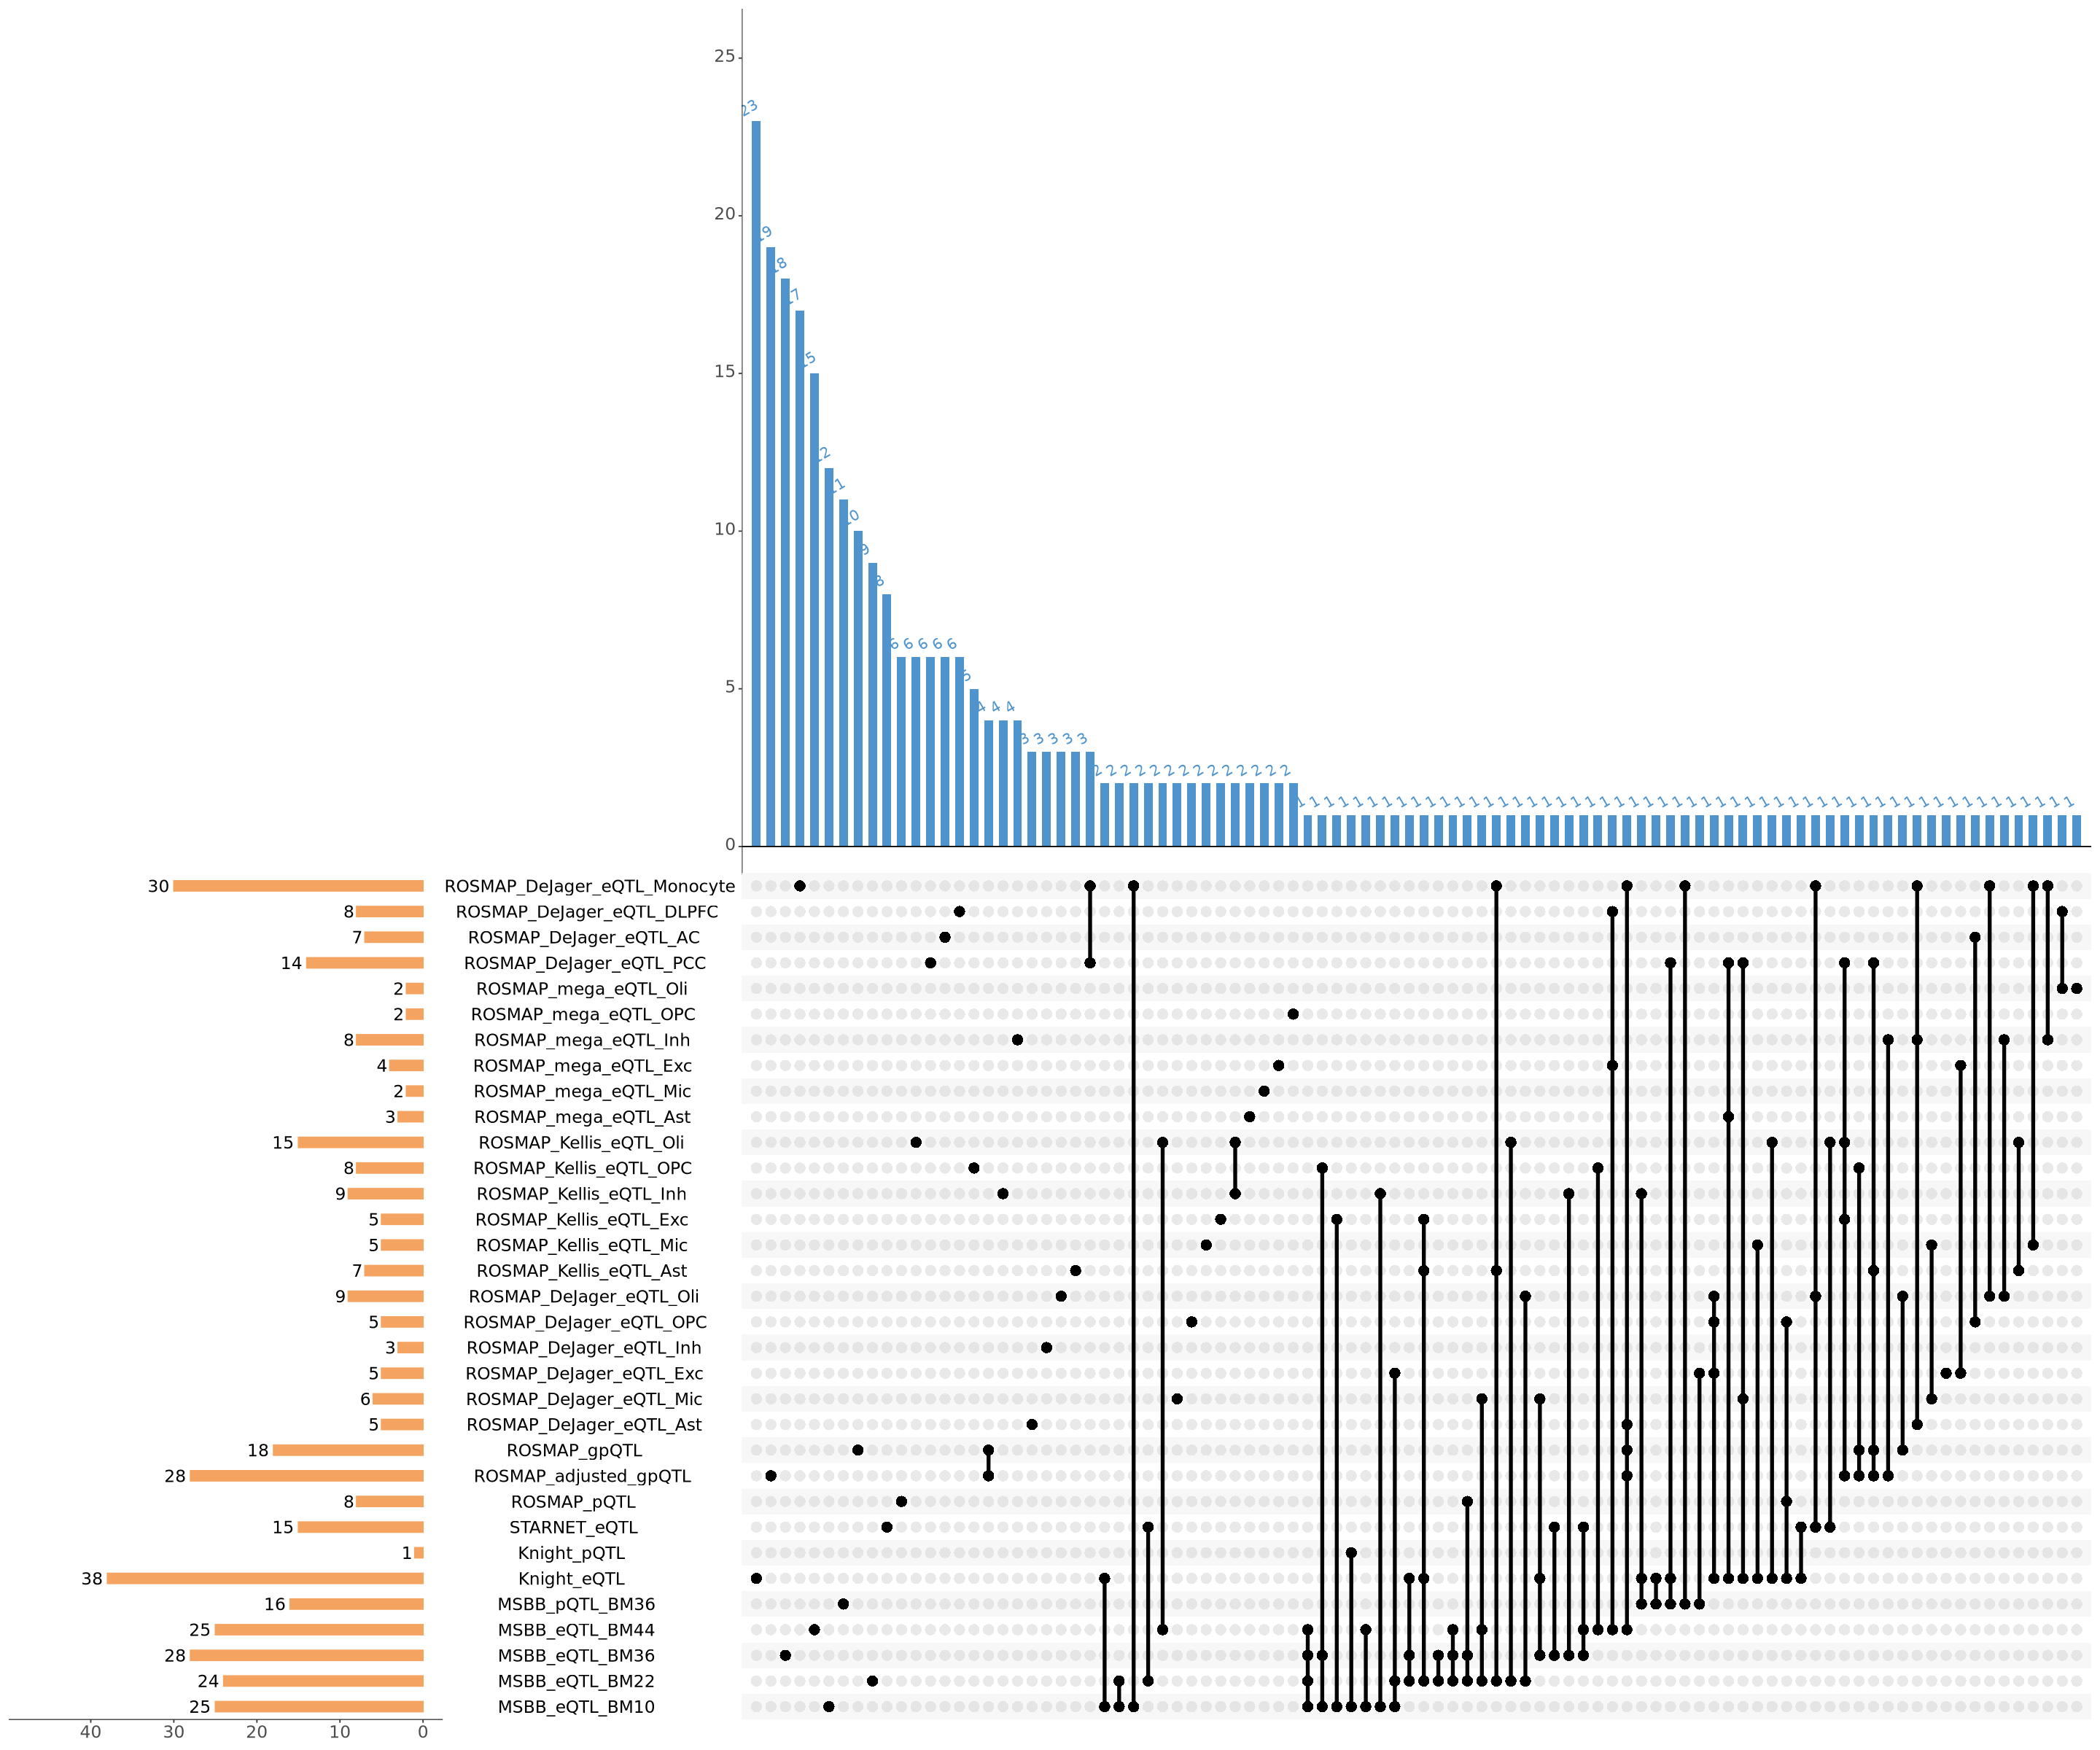

In [52]:
options(repr.plot.width = 24, repr.plot.height = 20)
library("UpSetR")
max_size <- max(sapply(coloc, length))
upset(fromList(coloc), 
            order.by = "freq", 
            keep.order = T,
            main.bar.color = "steelblue3", 
            sets.bar.color = "sandybrown", 
            text.scale = c(2,2,2,2,2), # Adjust font sizes for the main title, set names, set sizes, intersection sizes, and axis titles
            matrix.color = "black", # Adjust the color of matrix dots
            number.angles = 30, # Adjust the angle of number labels, useful for some plots
            mb.ratio = c(0.5, 0.5), # Adjust the ratio of main bar and sets bar
            point.size = 4, line.size = 1.5,
            sets = all_contexts,  
            nsets = length(coloc),
            set_size.show = TRUE,
            set_size.angles = 0,
            set_size.numbers_size = 7,
            set_size.scale_max = max_size + 0.25*max_size,
            nintersects = 100,
            mainbar.y.label = "",
            sets.x.label = NULL)

## 2. Connect trans-xQTL to APOE $\epsilon$2 and APOE $\epsilon$4 
Calculate LD between trans-xQTL and APOE $\epsilon$2/APOE $\epsilon$4

- **Important**: ROSMAP_gpQTL_gp_1629 identified a 95\% CS including APOE $\epsilon$2 with other 5 variants.
- Across all 5,616 xQTLs (3,596 unique trans-xQTL), correlations with APOE $\epsilon$2 range from -0.322 to 1, while correlations with APOE $\epsilon$4 range from -0.259 to 0.306.
- Need to discuss.

In [75]:
trans_in_APOE <- readRDS("trans_xqtl_APOE_all_cohorts_addGWAS.rds")
trans_in_APOE %>% pull(APOE2_cor) %>% range(., na.rm = TRUE)
trans_in_APOE %>% pull(APOE4_cor) %>% range(., na.rm = TRUE)

[1] -0.2203979  1.0000000

[1] -0.3228535  0.8370221

In [76]:
APOE2 <- "chr19:44908822:C:T"
APOE4 <- "chr19:44908684:T:C"
trans_in_APOE %>% filter(variant_ID %in% c(APOE2, APOE4))

#chr,start,end,a1,a2,variant_ID,MAF,betahat,sebetahat,z,⋯,cs_id,cohort,APOE2_cor,APOE4_cor,AD_Bellenguez,AD_Kunkle_Stage1_2019,AD_Wightman_Full_2021,AD_Wightman_Excluding23andMe_2021,AD_Wightman_ExcludingUKBand23andME_2021,AD_Bellenguez_EADB_2022
<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,44908821,44908822,T,C,chr19:44908822:C:T,0.08386076,-0.3192714,0.05673898,-5.627022,⋯,chr19_42346101_44935906_ROSMAP_gpQTL_gp_1629_1,ROSMAP,1,-0.1378542,NA,52.19375,178.8557,156.2673,109.7825,126.159


In [85]:
trans_in_APOE %>% filter(cs_id == "chr19_42346101_44935906_ROSMAP_gpQTL_gp_1629_1")

#chr,start,end,a1,a2,variant_ID,MAF,betahat,sebetahat,z,⋯,cs_id,cohort,APOE2_cor,APOE4_cor,AD_Bellenguez,AD_Kunkle_Stage1_2019,AD_Wightman_Full_2021,AD_Wightman_Excluding23andMe_2021,AD_Wightman_ExcludingUKBand23andME_2021,AD_Bellenguez_EADB_2022
<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,44908821,44908822,T,C,chr19:44908822:C:T,0.08386076,-0.3192714,0.05673898,-5.627022,⋯,chr19_42346101_44935906_ROSMAP_gpQTL_gp_1629_1,ROSMAP,1.0000000,-0.13785423,NA,52.19375217,178.8557,156.26731697,109.7825161,126.1590030
19,44909975,44909976,TGGT,GGGT,chr19:44909976:GGGT:TGGT,0.08386076,-0.3192714,0.05673898,-5.627022,⋯,chr19_42346101_44935906_ROSMAP_gpQTL_gp_1629_1,ROSMAP,0.9969070,-0.13683048,NA,NA,NA,NA,NA,NA
19,44911141,44911142,A,C,chr19:44911142:C:A,0.10284810,-0.2809271,0.05144824,-5.460384,⋯,chr19_42346101_44935906_ROSMAP_gpQTL_gp_1629_1,ROSMAP,0.8491625,0.09132053,0.02858498,0.23634743,NA,0.10051139,0.8955129,0.5931449
19,44912382,44912383,A,G,chr19:44912383:G:A,0.10284810,-0.2809271,0.05144824,-5.460384,⋯,chr19_42346101_44935906_ROSMAP_gpQTL_gp_1629_1,ROSMAP,0.8491625,0.09132053,0.93107239,0.08618615,NA,0.05036407,1.3297541,1.4118662
19,44913573,44913574,G,T,chr19:44913574:T:G,0.10284810,-0.2809271,0.05144824,-5.460384,⋯,chr19_42346101_44935906_ROSMAP_gpQTL_gp_1629_1,ROSMAP,0.8491625,0.09132053,NA,NA,NA,0.04778777,NA,1.3262734


In [86]:
trans_in_APOE %>% colnames

[1] "#chr"                                   
 [2] "start"                                  
 [3] "end"                                    
 [4] "a1"                                     
 [5] "a2"                                     
 [6] "variant_ID"                             
 [7] "MAF"                                    
 [8] "betahat"                                
 [9] "sebetahat"                              
[10] "z"                                      
[11] "gene_ID"                                
[12] "event_ID"                               
[13] "cs_coverage_0.95"                       
[14] "cs_coverage_0.7"                        
[15] "cs_coverage_0.5"                        
[16] "PIP"                                    
[17] "conditional_effect"                     
[18] "resource"                               
[19] "p"                                      
[20] "cs_id"                                  
[21] "cohort"                                 
[22] "APOE2_cor"                              
[23] "APOE4_cor"                              
[24] "AD_Bellenguez"                          
[25] "AD_Kunkle_Stage1_2019"                  
[26] "AD_Wightman_Full_2021"                  
[27] "AD_Wightman_Excluding23andMe_2021"      
[28] "AD_Wightman_ExcludingUKBand23andME_2021"
[29] "AD_Bellenguez_EADB_2022"

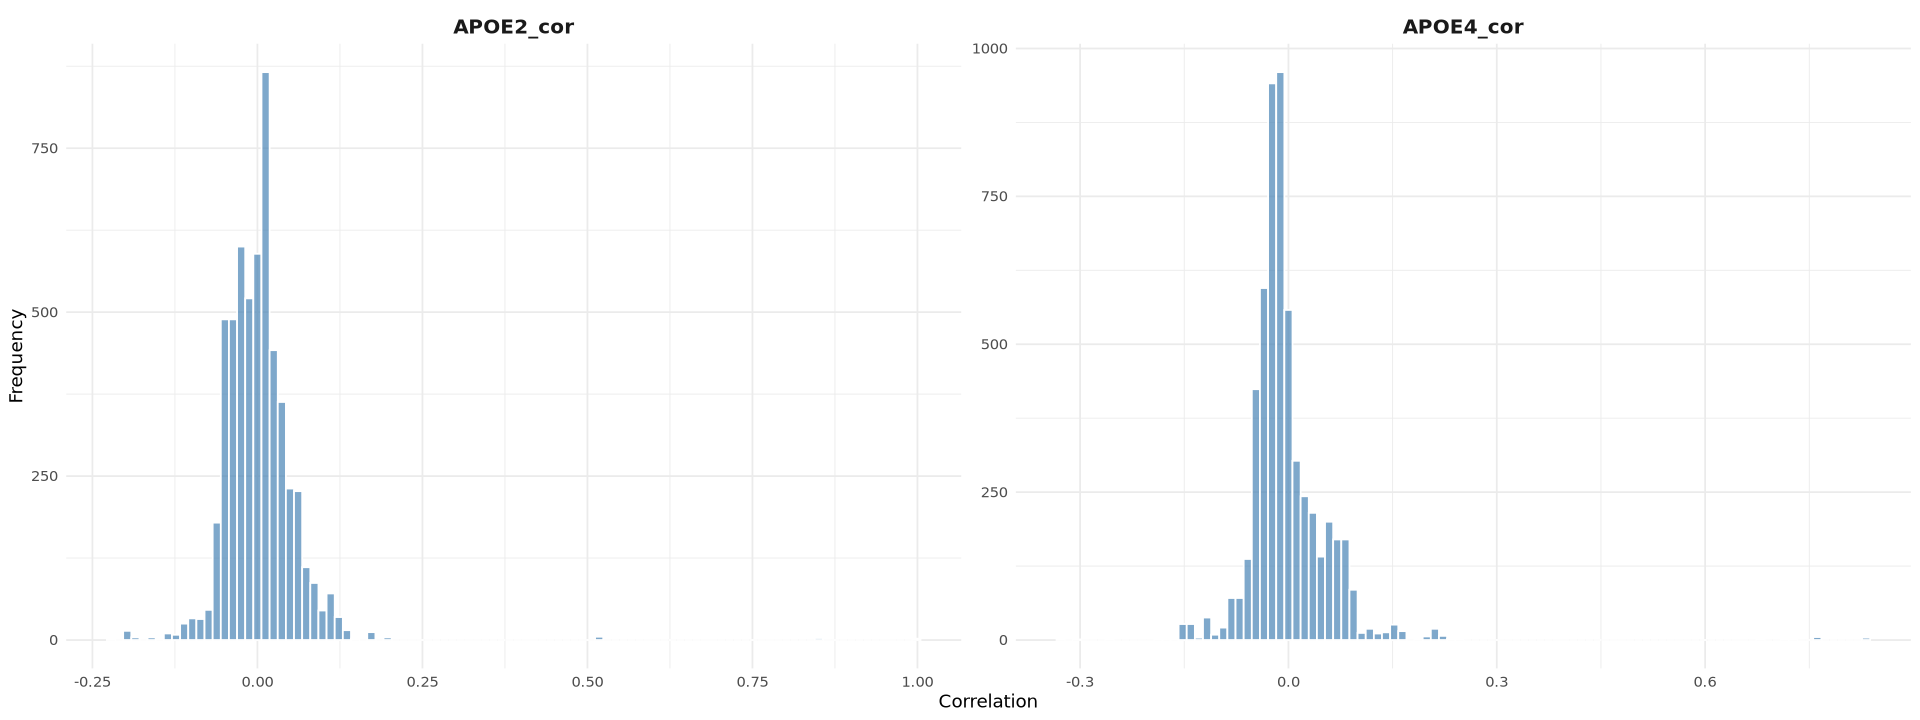

In [77]:
options(repr.plot.width = 16, repr.plot.height = 6)
library(ggplot2)
library(dplyr)
library(tidyr)

# Reshape data from wide to long format
apoe_long <- trans_in_APOE %>%
  select(APOE2_cor, APOE4_cor) %>%
  pivot_longer(cols = c(APOE2_cor, APOE4_cor), 
               names_to = "APOE_type", 
               values_to = "correlation") %>%
  filter(!is.na(correlation))  # Remove NA values

# Create faceted histogram
ggplot(apoe_long, aes(x = correlation)) +
  geom_histogram(bins = 100, fill = "steelblue", alpha = 0.7, color = "white") +
  facet_wrap(~ APOE_type, scales = "free") +
  labs(title = NULL, # "Distribution of APOE Correlations",
       x = "Correlation",
       y = "Frequency") +
  theme_minimal() +
  theme(strip.text = element_text(size = 12, face = "bold"))

In [82]:
trans_in_APOE %>% filter(abs(APOE2_cor)>0.5 | abs(APOE4_cor)>0.5) %>% pull(event_ID) %>% unique

[1] "STARNET_eQTL_ENSG00000003402"                
[2] "MSBB_eQTL_BM10_ENSG00000110719"              
[3] "MSBB_eQTL_BM10_ENSG00000229515"              
[4] "ROSMAP_DeJager_eQTL_Monocyte_ENSG00000111647"
[5] "ROSMAP_gpQTL_gp_1629"

In [83]:
trans_in_APOE %>% filter(abs(APOE2_cor)>0.2 | abs(APOE4_cor)>0.2) %>% pull(event_ID) %>% unique

[1] "Knight_eQTL_ENSG00000276213"                 
 [2] "MSBB_eQTL_BM36_ENSG00000230790"              
 [3] "MSBB_eQTL_BM36_ENSG00000287207"              
 [4] "STARNET_eQTL_ENSG00000003402"                
 [5] "STARNET_eQTL_ENSG00000151304"                
 [6] "MSBB_eQTL_BM44_ENSG00000223298"              
 [7] "MSBB_eQTL_BM10_ENSG00000110719"              
 [8] "MSBB_eQTL_BM10_ENSG00000229515"              
 [9] "ROSMAP_DeJager_eQTL_Monocyte_ENSG00000111647"
[10] "ROSMAP_gpQTL_gp_1629"                        
[11] "MSBB_eQTL_BM22_ENSG00000265547"              
[12] "ROSMAP_mega_eQTL_Exc_ENSG00000104047"